# Variability in the Ross Sea

As shown in the Ross Sea comparison to obs, the model captures the recent rebound in salinity (i.e. Silvano et al 2020, Castagno et al. 2019). The model also simulates a large increase in salinity in the 1990s/2000s that doesn't seem to be in the obs.

Let's investigate the simulated Ross Sea variability a bit more. e.g. what's the spatial pattern of the T/S anomalies (in lat/lon/depth space)? Is the variability driven by sea ice advection into the Ross Sea from upstream as proposed by Silvano et al. 2020?

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
from dask.distributed import Client
import os.path
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import sys
# adding the parent directory to the sys.path
sys.path.append("../") 
from iav_AABW_functions import (
    yearly_mean, mask_from_polygon,shelf_mask_isobath,
    fix_coordinates_of_ice_model)

import cmocean.cm as cmo
import matplotlib.ticker as mticker
import datetime
import calendar

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44989,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35059,Total threads: 4
Dashboard: /proxy/36905/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:33885,


In [4]:
session = cc.database.create_session()

exp_ctrl = '01deg_jra55v140_iaf_cycle4'
exp_melt = '01deg_jra55v140_iaf_cycle4_MWpert'

start_time = '1979-01-01'
end_time = '2018-12-31'
frequency = '1 monthly'

lat_slice = slice(-80, -59)

## Load data

In [5]:
# Observations from Jacobs et al., 2022: summer (DJF) salinities in the
# Ross Sea in various regions and depth-ranges
df_Jacobs2022= pd.read_csv(
    '/g/data/e14/kg5128/IAF_meltwater/obs_data/Jacobs_et_al_2022_data.csv') 

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(exp_ctrl, 'ht', session, n=1).sel(
    yt_ocean=slice(-90, -60))
land_mask = (ht*0).fillna(1)
area_t = cc.querying.getvar(
    exp_ctrl, 'area_t', session, n=1,
    chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
area_u = cc.querying.getvar(
    exp_ctrl, 'area_u', session, n=1,
    chunks={'yu_ocean': '100MB', 'xu_ocean': '100MB'})

In [12]:
%%time
salt = cc.querying.getvar(
    exp_melt, 'salt', session, frequency=frequency, start_time=start_time,
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'})
salt = salt.sel(xt_ocean=slice(160-360, -155), yt_ocean=slice(-79, -70)).isel(
    st_ocean=slice(48)).compute()

CPU times: user 35.6 s, sys: 15.1 s, total: 50.7 s
Wall time: 1min 55s


In [9]:
%%time
salt_ctrl = cc.querying.getvar(
    exp_ctrl, 'salt', session, frequency=frequency, start_time='1958-01-01',
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'})
salt_ctrl = salt_ctrl.sel(xt_ocean=slice(160-360, -155), yt_ocean=slice(-79, -70)).isel(
    st_ocean=slice(48)).compute()

CPU times: user 30.7 s, sys: 22.6 s, total: 53.3 s
Wall time: 1min 34s


In [10]:
salt_shelf = shelf_mask_isobath(salt)
salt_shelf_DJF = salt_shelf.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=salt.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

In [11]:
salt_TNB = salt.sel(
    xt_ocean=slice(163.4-360, 166-360), yt_ocean=slice(-75.3, -74.83))
salt_TNB_DJF = salt_TNB.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=salt.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

salt_ctrl_TNB = salt_ctrl.sel(
    xt_ocean=slice(163.4-360, 166-360), yt_ocean=slice(-75.3, -74.83))
salt_ctrl_TNB_DJF = salt_ctrl_TNB.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=salt_ctrl.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

In [12]:
salt_high = salt.sel(time=slice('2002', '2007')).mean('time')
salt_low = salt.sel(time=slice('2010', '2013')).mean('time')

In [13]:
%%time
salt_200m = cc.querying.getvar(
    exp_melt, 'salt', session, frequency=frequency, start_time=start_time,
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'})
salt_200m = salt_200m.sel(yt_ocean=slice(-79, -60), time=slice('2000', None)).isel(
    st_ocean=30).compute()  # xt_ocean=slice(160-360, -60)

CPU times: user 17.6 s, sys: 3.48 s, total: 21.1 s
Wall time: 1min 51s


In [14]:
salt_200m_high = salt_200m.sel(time=slice('2002', '2007')).mean('time')
salt_200m_low = salt_200m.sel(time=slice('2010', '2013')).mean('time')

In [15]:
%%time
salt_WA = cc.querying.getvar(
    exp_melt, 'salt', session, frequency=frequency, start_time=start_time,
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'})
salt_WA = salt_WA.sel(xt_ocean=slice(160-360, -90), yt_ocean=slice(-79, -68),
                      time=slice('2000', None)).isel(st_ocean=slice(48)).compute()

CPU times: user 26.7 s, sys: 24.2 s, total: 50.9 s
Wall time: 1min 49s


In [16]:
salt_WA_high = salt_WA.sel(time=slice('2002', '2007')).mean('time')
salt_WA_low = salt_WA.sel(time=slice('2010', '2013')).mean('time')

In [17]:
s, shelf_mask = shelf_mask_isobath(salt_200m_high, True)

### temperature

In [17]:
%%time
temp = cc.querying.getvar(
    exp_melt, 'temp', session, frequency=frequency, start_time=start_time,
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'}) - 273.15
temp = temp.sel(xt_ocean=slice(160-360, -155), yt_ocean=slice(-79, -70)).isel(
    st_ocean=slice(48)).compute()

CPU times: user 1min 12s, sys: 18.2 s, total: 1min 30s
Wall time: 5min 17s


In [18]:
%%time
temp_ctrl = cc.querying.getvar(
    exp_ctrl, 'temp', session, frequency=frequency, start_time='1958-01-01',
    end_time=end_time, chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'}) - 273.15
temp_ctrl = temp_ctrl.sel(xt_ocean=slice(160-360, -155), yt_ocean=slice(-79, -70)).isel(
    st_ocean=slice(48)).compute()

CPU times: user 2min 29s, sys: 32.6 s, total: 3min 2s
Wall time: 12min


In [19]:
temp_shelf = shelf_mask_isobath(temp)
temp_shelf_DJF = temp_shelf.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=temp.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

In [20]:
temp_TNB = temp.sel(
    xt_ocean=slice(163.4-360, 166-360), yt_ocean=slice(-75.3, -74.83))
temp_TNB_DJF = temp_TNB.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=temp.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

temp_ctrl_TNB = temp_ctrl.sel(
    xt_ocean=slice(163.4-360, 166-360), yt_ocean=slice(-75.3, -74.83))
temp_ctrl_TNB_DJF = temp_ctrl_TNB.sel(st_ocean=slice(850, 950)).mean(
    ['xt_ocean', 'yt_ocean', 'st_ocean']).sel(
    time=temp_ctrl.time.dt.month.isin([12, 1, 2]))[2:-1].coarsen(time=3).mean()

In [21]:
temp_high = temp.sel(time=slice('2002', '2007')).mean('time')
temp_low = temp.sel(time=slice('2010', '2013')).mean('time')

### sea ice

In [7]:
%%time
frazil_ice_growth = cc.querying.getvar(
    exp_melt, 'frazil_m', session, frequency=frequency, decode_coords=False,
    chunks={'ni': '200MB', 'nj': '200MB'})
congel_ice_growth = cc.querying.getvar(
    exp_melt, 'congel_m', session, frequency=frequency, decode_coords=False,
    chunks={'ni': '200MB', 'nj': '200MB'})
ice_conc = cc.querying.getvar(
    exp_melt, 'aice_m', session, frequency=frequency, decode_coords=False,
    chunks={'ni': '200MB', 'nj': '200MB'})
(frazil_ice_growth, congel_ice_growth, ice_conc) = tuple(map(
    fix_coordinates_of_ice_model, (frazil_ice_growth, congel_ice_growth, ice_conc),
    (area_t, area_t, area_t)))
ice_growth = frazil_ice_growth + congel_ice_growth
ice_growth = ice_growth.sel(xt_ocean=slice(160-360, -60), yt_ocean=slice(-79, -68)).compute()
ice_conc = 100*ice_conc.sel(xt_ocean=slice(160-360, -60), yt_ocean=slice(-79, -68)).compute()

Fixed time assuming monthly resolution
Fixed time assuming monthly resolution
Fixed time assuming monthly resolution
CPU times: user 1min 8s, sys: 8.32 s, total: 1min 17s
Wall time: 3min 33s


In [8]:
# calculated and saved in cell below
ice_transp = xr.open_dataarray(
    '/home/142/cs6673/work/meltwater/data_Ross_Sea_variability/ice_transp_across_section_' +
    'east_of_Ross_Sea_' + exp_melt + '_1d_' + start_time[:4] + '-' + end_time[:4] + '.nc')

## Plots

In [22]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

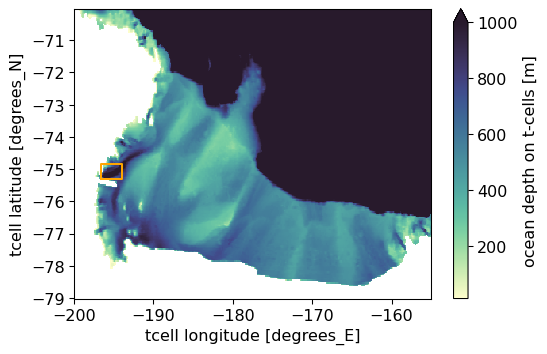

In [23]:
ht.sel(xt_ocean=slice(160-360, -155), yt_ocean=slice(-79, -70)).plot(
    cmap=cmo.deep, vmax=1000)
plt.plot([163.4-360, 166-360, 166-360, 163.4-360,163.4-360],
         [-75.3, -75.3, -74.83, -74.83, -75.3], 'orange')
plt.show()

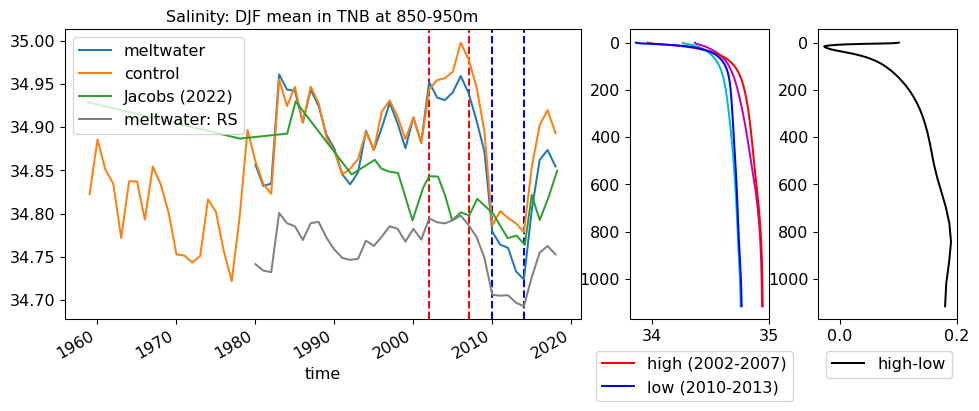

In [24]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=.35)
plt.subplot(1, 5, (1, 3))
plt.axvline(datetime.datetime(2002, 1, 16), color='r', linestyle='--')
plt.axvline(datetime.datetime(2007, 1, 16), color='r', linestyle='--')
plt.axvline(datetime.datetime(2010, 1, 16), color='b', linestyle='--')
plt.axvline(datetime.datetime(2014, 1, 16), color='b', linestyle='--')
# plt.axvline(datetime.datetime(2015, 1, 16), color='k', linestyle='--')
# plt.axvline(datetime.datetime(2018, 1, 16), color='k', linestyle='--')
salt_TNB_DJF.plot(label='meltwater')
salt_ctrl_TNB_DJF.plot(label='control')
plt.plot(pd.to_datetime(df_Jacobs2022.TNB_Date_Time, format='%Y-%m-%d'),
         df_Jacobs2022['TNB_850to900m_Salinity'], label='Jacobs (2022)')
salt_shelf_DJF.plot(color='grey', label='meltwater: RS')
plt.title('Salinity: DJF mean in TNB at 850-950m')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=slice('2002', '2007')).mean('time'), salt_TNB.st_ocean,
        color='m')
plt.plot(salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=salt_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2002', '2007')).mean('time'), salt_TNB.st_ocean,
        color='r', label='high (2002-2007)')
plt.plot(salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=slice('2010', '2013')).mean('time'), salt_TNB.st_ocean,
         color='c')
plt.plot(salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=salt_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2010', '2013')).mean('time'), salt_TNB.st_ocean,
         color='b', label='low (2010-2013)')
plt.gca().invert_yaxis()
plt.legend(loc='upper left', bbox_to_anchor=(-.3, -.08))

plt.subplot(1, 5, 5)
plt.plot(salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=salt_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2002', '2007')).mean('time')-
         salt_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=salt_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2010', '2013')).mean('time'), salt_TNB.st_ocean,
        color='k', label='high-low')
plt.gca().invert_yaxis()
plt.legend(loc='upper left', bbox_to_anchor=(0, -.08))
plt.show()

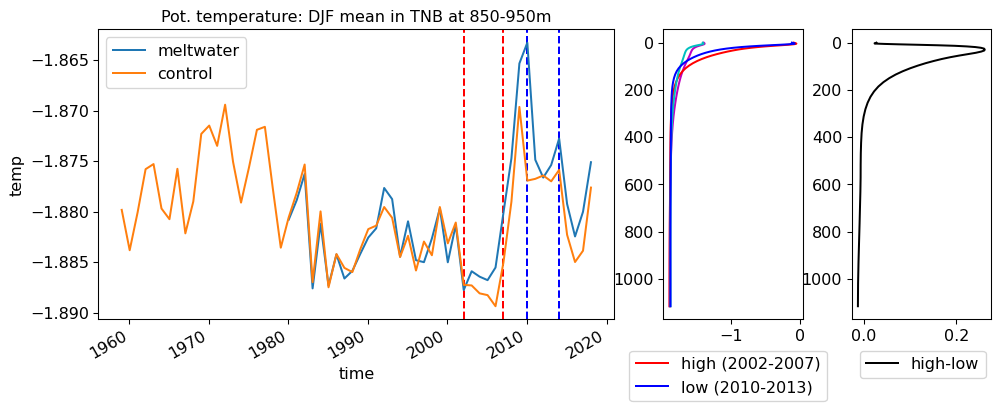

In [28]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=.35)
plt.subplot(1, 5, (1, 3))
plt.axvline(datetime.datetime(2002, 1, 16), color='r', linestyle='--')
plt.axvline(datetime.datetime(2007, 1, 16), color='r', linestyle='--')
plt.axvline(datetime.datetime(2010, 1, 16), color='b', linestyle='--')
plt.axvline(datetime.datetime(2014, 1, 16), color='b', linestyle='--')
# plt.axvline(datetime.datetime(2015, 1, 16), color='k', linestyle='--')
# plt.axvline(datetime.datetime(2018, 1, 16), color='k', linestyle='--')
temp_TNB_DJF.plot(label='meltwater')
temp_ctrl_TNB_DJF.plot(label='control')
# plt.plot(pd.to_datetime(df_Jacobs2022.TNB_Date_Time, format='%Y-%m-%d'),
#          df_Jacobs2022['RI_500m_Temperature'], label='Jacobs (2022)')
# temp_shelf_DJF.plot(color='grey', label='meltwater: RS')
plt.title('Pot. temperature: DJF mean in TNB at 850-950m')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=slice('2002', '2007')).mean('time'), temp_TNB.st_ocean,
        color='m')
plt.plot(temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=temp_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2002', '2007')).mean('time'), temp_TNB.st_ocean,
        color='r', label='high (2002-2007)')
plt.plot(temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=slice('2010', '2013')).mean('time'), temp_TNB.st_ocean,
         color='c')
plt.plot(temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=temp_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2010', '2013')).mean('time'), temp_TNB.st_ocean,
         color='b', label='low (2010-2013)')
plt.gca().invert_yaxis()
plt.legend(loc='upper left', bbox_to_anchor=(-.3, -.08))

plt.subplot(1, 5, 5)
plt.plot(temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=temp_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2002', '2007')).mean('time')-
         temp_TNB.mean(['xt_ocean', 'yt_ocean']).sel(
    time=temp_TNB.time.dt.month.isin([12, 1, 2])).sel(
    time=slice('2010', '2013')).mean('time'), temp_TNB.st_ocean,
        color='k', label='high-low')
plt.gca().invert_yaxis()
plt.legend(loc='upper left', bbox_to_anchor=(0, -.08))
plt.show()

period of high salinity coincides with low temperatures

in the period of low salinity the temperatures are a little higher than average but maximum temperatures occur in the year just before that period 

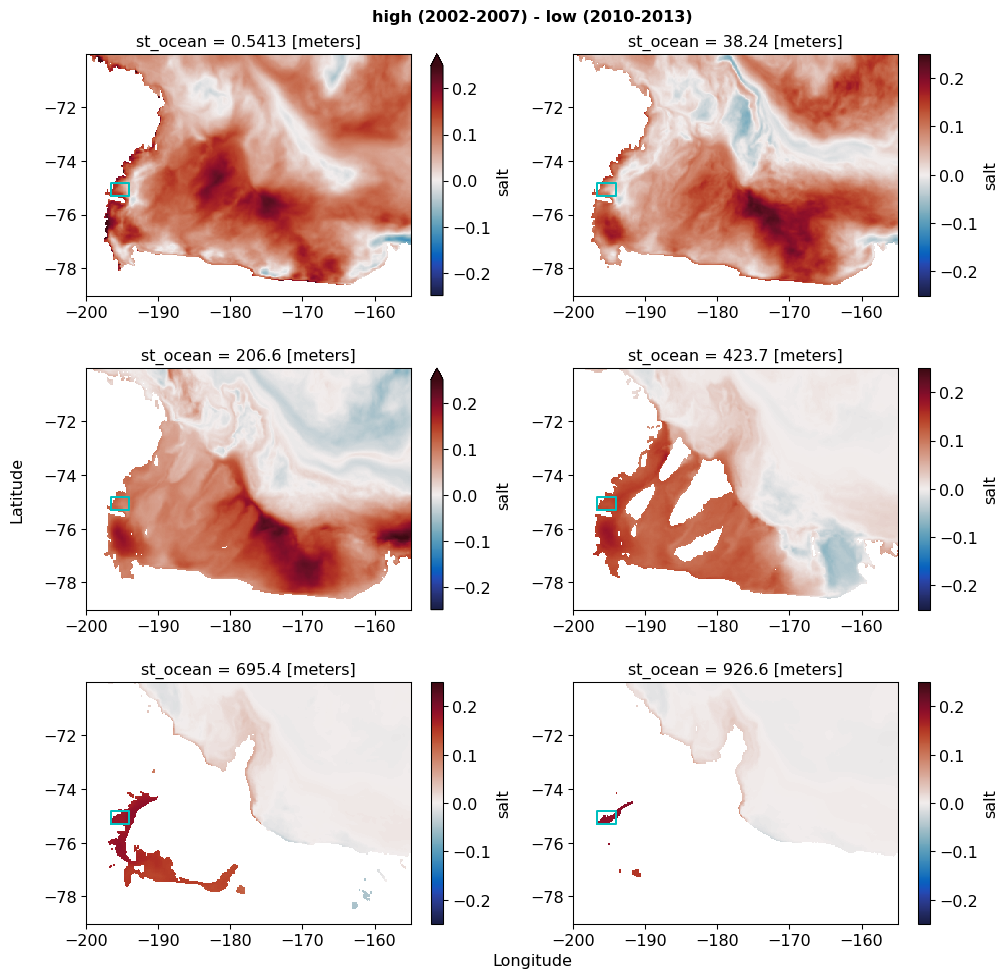

In [30]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.3)

v_max=.25
k_all = [0, 15, 30, 37, 42, 45]
for n in range(6):
    plt.subplot(3, 2, n+1)
    (salt_high-salt_low)[k_all[n], :, :].plot(vmin=-v_max, vmax=v_max, cmap=cmo.balance)
    plt.plot([163.4-360, 166-360, 166-360, 163.4-360,163.4-360],
         [-75.3, -75.3, -74.83, -74.83, -75.3], 'c')
    plt.xlabel('')
    plt.ylabel('')

ax = plt.gcf().add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude', labelpad=20)
ax.set_title('high (2002-2007) - low (2010-2013)', fontweight='bold', pad=25)
plt.show()

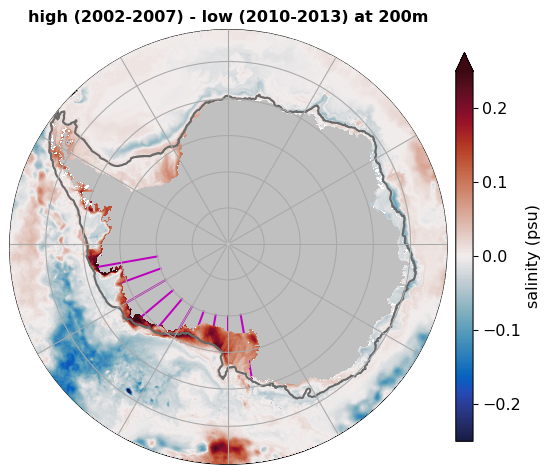

In [31]:
fig = plt.figure(figsize=(6, 6))

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

gl = ax.gridlines(draw_labels=False, color='darkgray', zorder=4)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

ax.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)
p = ax.pcolormesh(salt_200m.xt_ocean, salt_200m.yt_ocean,
                  salt_200m_high-salt_200m_low, vmin=-v_max, vmax=v_max,
                  cmap=cmo.balance, transform=ccrs.PlateCarree(),
                  rasterized=True, zorder=3)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'dimgrey', linewidth=.7,
            transform=ccrs.PlateCarree(), zorder=4)
plt.title('high (2002-2007) - low (2010-2013) at 200m', fontweight='bold')
for n in range(10):
    plt.plot([-100-n*10, -100-n*10], [-80, -68], 'm', transform=ccrs.PlateCarree())

padx, pady, width = (0.015, .04, 0.03)
pos = ax.get_position()
cax = plt.axes([pos.xmax+padx, pos.ymin+pady, width, (pos.ymax-pos.ymin)-2*pady])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
cb.ax.set_ylabel('salinity (psu)')

plt.show()

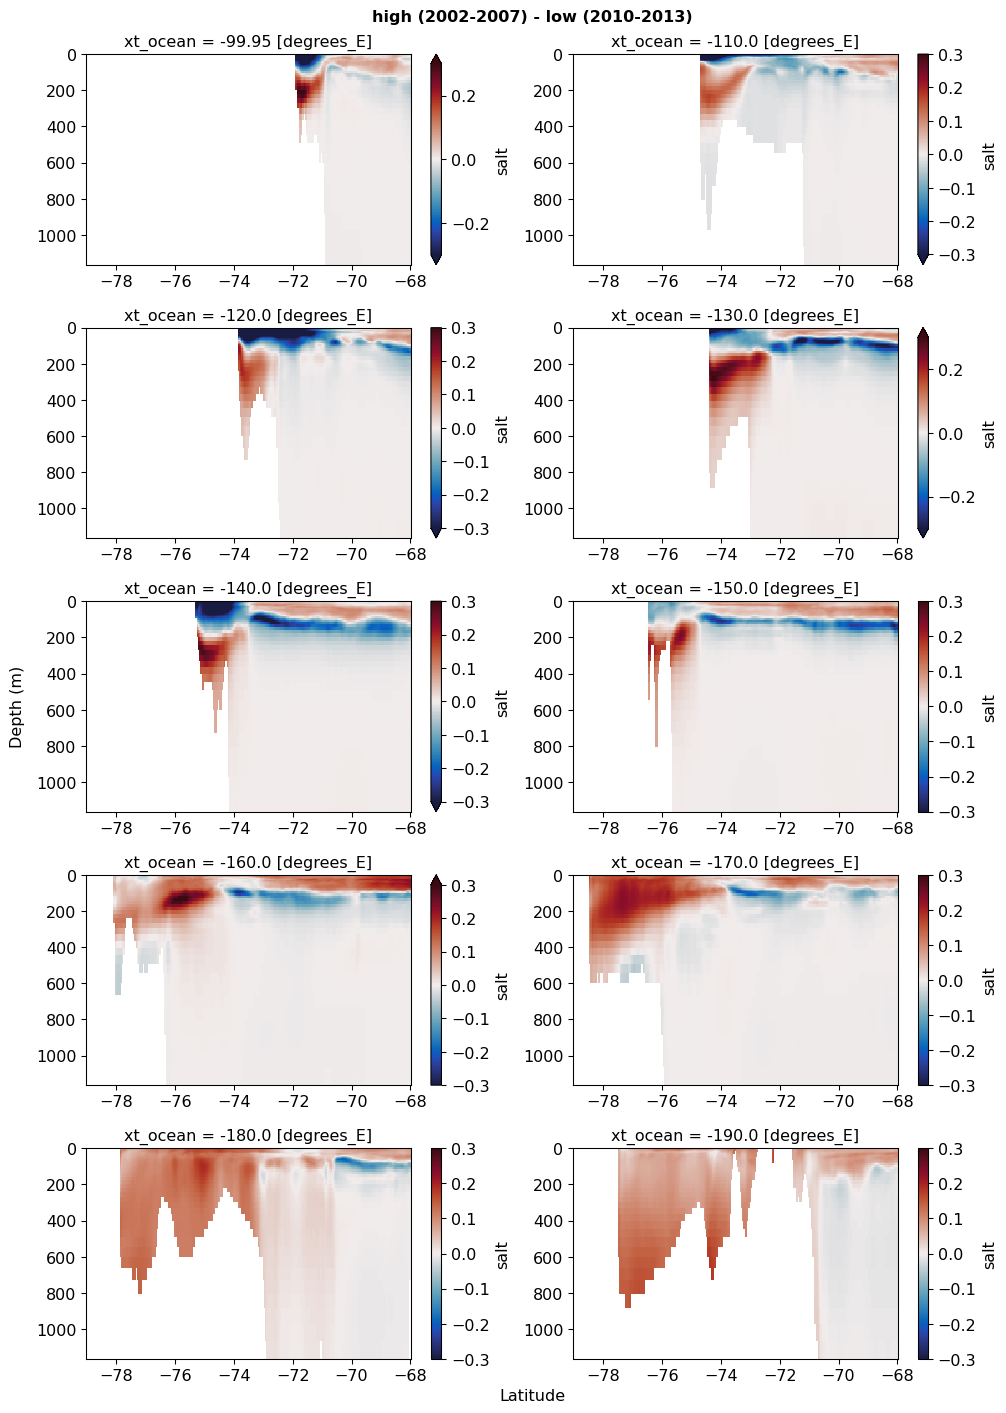

In [17]:
plt.figure(figsize=(12, 18))
plt.subplots_adjust(hspace=.3)

v_max=.3
for n in range(10):
    plt.subplot(5, 2, n+1)
    (salt_WA_high-salt_WA_low).sel(xt_ocean=-100-n*10, method='nearest').plot(
        vmin=-v_max, vmax=v_max, cmap=cmo.balance)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')

ax = plt.gcf().add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)', labelpad=20)
ax.set_title('high (2002-2007) - low (2010-2013)', fontweight='bold', pad=25)
plt.show()

salinity anomalies are not within areas of coherent zonal velocities 

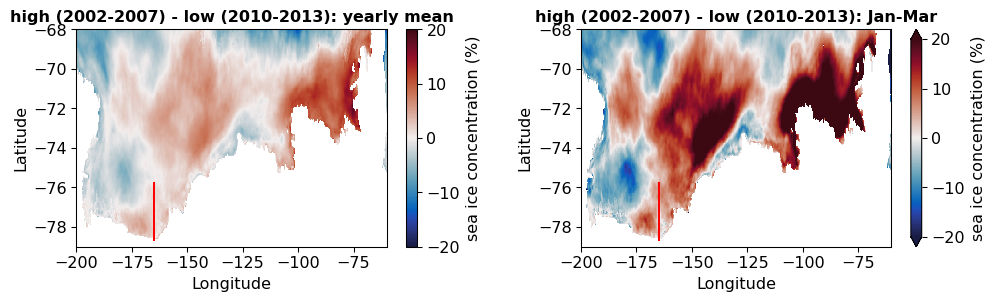

In [14]:
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=.3)

v_max = 20
plt.subplot(1, 2, 1)
(ice_conc.sel(time=slice('2002', '2007')).mean('time') -
 ice_conc.sel(time=slice('2010', '2013')).mean('time')).plot(
    vmin=-v_max, vmax=v_max, cmap=cmo.balance,
    cbar_kwargs={'label': 'sea ice concentration (%)'})
plt.plot(-165*np.ones(ice_transp.yu_ocean.size), ice_transp.yu_ocean, 'r')
plt.title('high (2002-2007) - low (2010-2013): yearly mean', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
(ice_conc.sel(time=ice_conc.time.dt.month.isin([1, 2, 3])).sel(
    time=slice('2002', '2007')).mean('time') -
  ice_conc.sel(time=ice_conc.time.dt.month.isin([1, 2, 3])).sel(
      time=slice('2010', '2013')).mean('time')).plot(
    vmin=-v_max, vmax=v_max, cmap=cmo.balance,
    cbar_kwargs={'label': 'sea ice concentration (%)'})
plt.plot(-165*np.ones(ice_transp.yu_ocean.size), ice_transp.yu_ocean, 'r')
plt.title('high (2002-2007) - low (2010-2013): Jan-Mar', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

lower sea ice concentration in eastern Ross Sea in later summer (Jan-Mar), especially in March, and higher ice concentration in Bellingshausen/Amundsen/ western Ross Sea in years of high salinity compared to years of low salinity in Ross Sea

agrees with Silvano (2020) who found lower sea ice concentration in February in years of high salinity in Ross Sea

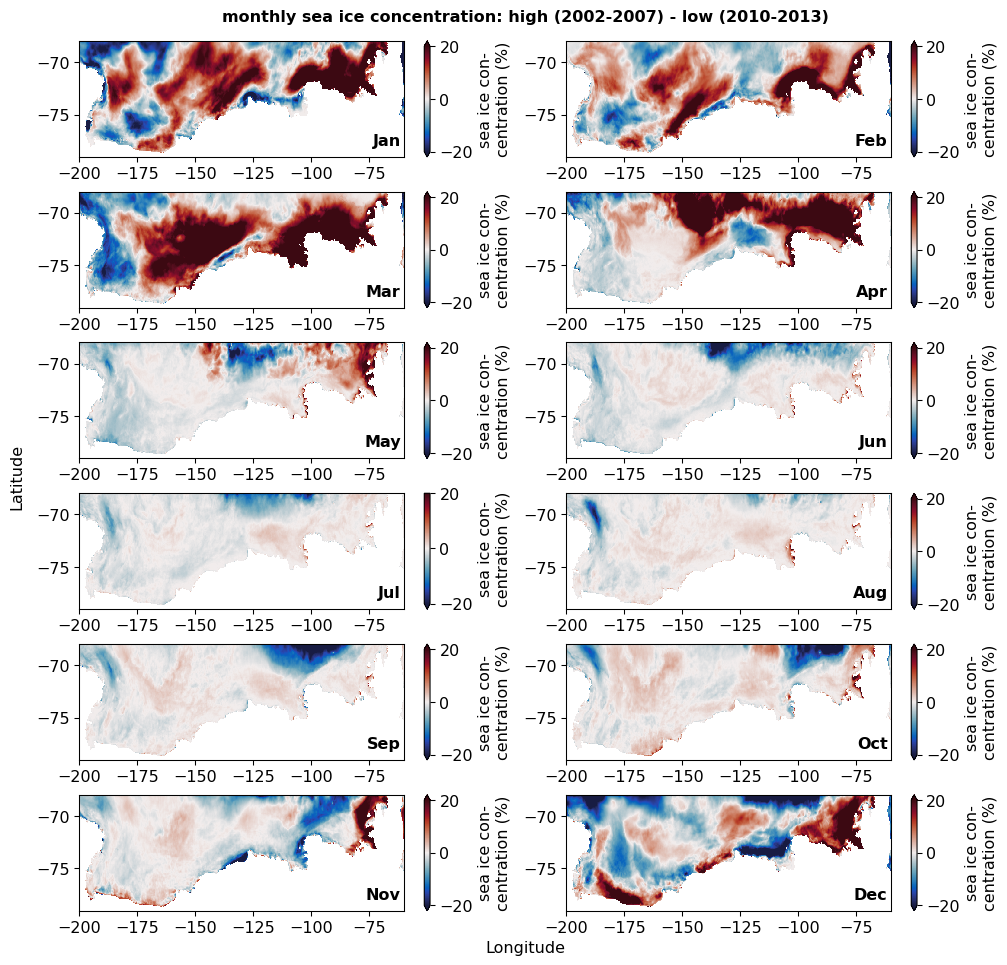

In [46]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.3)
for m in range(1, 13):
    plt.subplot(6, 2, m)
    (ice_conc.sel(time=ice_conc.time.dt.month.isin([m])).sel(
        time=slice('2002', '2007')).mean('time') -
     ice_conc.sel(time=ice_conc.time.dt.month.isin([m])).sel(
         time=slice('2010', '2013')).mean('time')).plot(
        vmin=-20, vmax=20, cmap=cmo.balance,
        cbar_kwargs={'label': 'sea ice con-\ncentration (%)'})
    plt.xlabel('')
    plt.ylabel('')
    plt.text(.99, 0.1, calendar.month_abbr[m], fontweight='bold',
             ha='right', transform=plt.gca().transAxes)

ax = plt.gcf().add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude', labelpad=15)
ax.set_title('monthly sea ice concentration: high (2002-2007) - low (2010-2013)',
             fontweight='bold', pad=15)

plt.show()

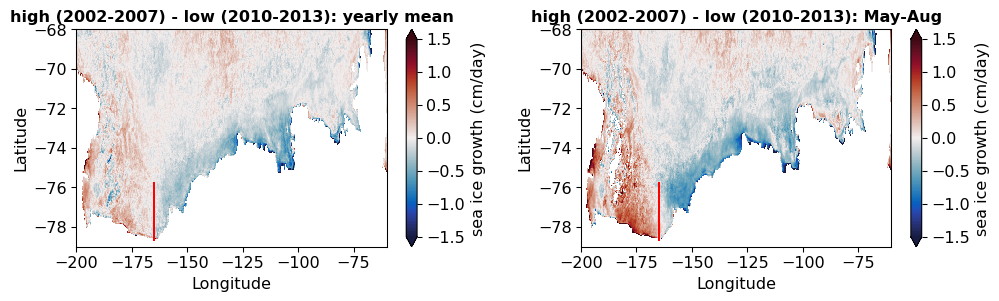

In [15]:
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=.3)

v_max = 1.5
plt.subplot(1, 2, 1)
(ice_growth.sel(time=slice('2002', '2007')).mean('time') -
 ice_growth.sel(time=slice('2010', '2013')).mean('time')).plot(
    vmin=-v_max, vmax=v_max, cmap=cmo.balance,
    cbar_kwargs={'label': 'sea ice growth (cm/day)'})
plt.plot(-165*np.ones(ice_transp.yu_ocean.size), ice_transp.yu_ocean, 'r')
plt.title('high (2002-2007) - low (2010-2013): yearly mean', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
(ice_growth.sel(time=ice_growth.time.dt.month.isin(np.arange(5, 9))).sel(
    time=slice('2002', '2007')).mean('time') -
  ice_growth.sel(time=ice_growth.time.dt.month.isin(np.arange(5, 9))).sel(
      time=slice('2010', '2013')).mean('time')).plot(
    vmin=-v_max, vmax=v_max, cmap=cmo.balance,
    cbar_kwargs={'label': 'sea ice growth (cm/day)'})
plt.plot(-165*np.ones(ice_transp.yu_ocean.size), ice_transp.yu_ocean, 'r')
plt.title('high (2002-2007) - low (2010-2013): May-Aug', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

increased sea ice growth in eastern Ross Sea (and decreased ice growth in Bellingshausen/Amundsen Sea) in years of high salinity compared to years of low salinity in Ross Sea

agrees with Silvano (2020) who found increased ice growth in early winter in years of high salinity in Ross Sea

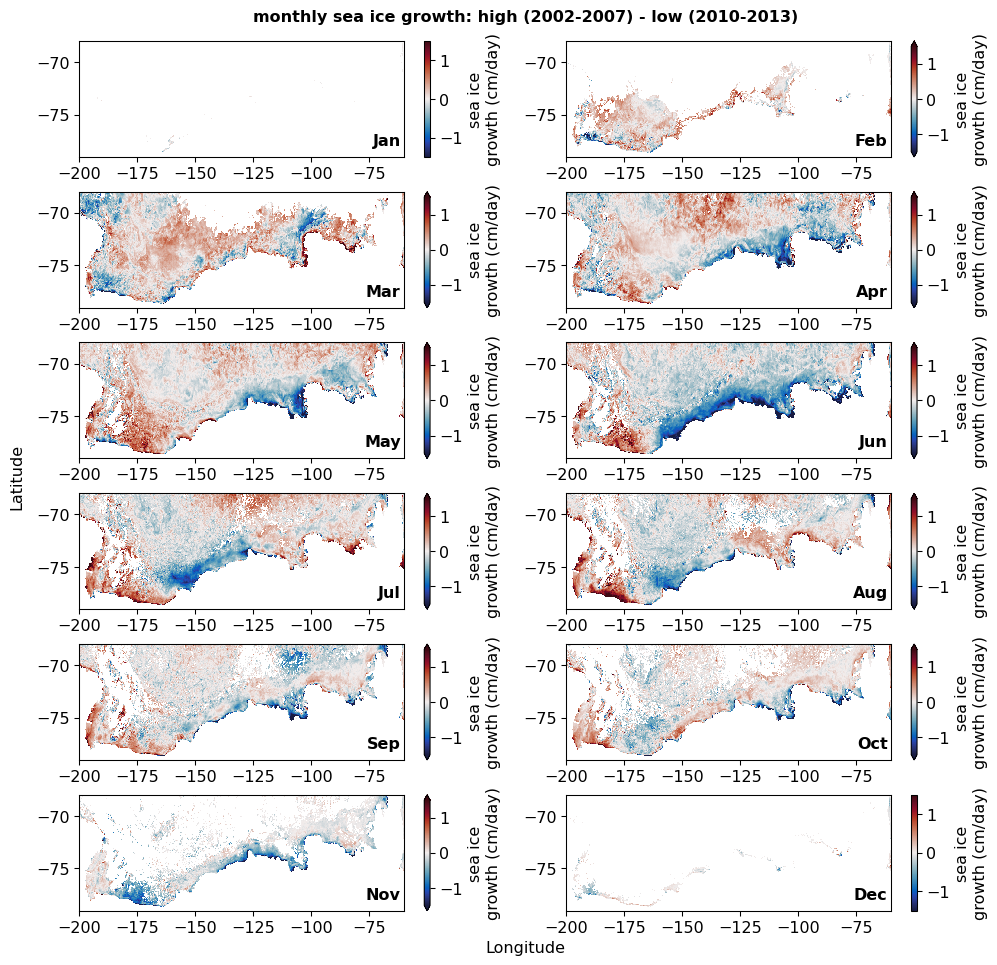

In [51]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.3)
for m in range(1, 13):
    plt.subplot(6, 2, m)
    (ice_growth.sel(time=ice_growth.time.dt.month.isin([m])).sel(
        time=slice('2002', '2007')).mean('time') -
     ice_growth.sel(time=ice_growth.time.dt.month.isin([m])).sel(
         time=slice('2010', '2013')).mean('time')).plot(
        vmin=-v_max, vmax=v_max, cmap=cmo.balance,
        cbar_kwargs={'label': 'sea ice\ngrowth (cm/day)'})
    plt.xlabel('')
    plt.ylabel('')
    plt.text(.99, 0.1, calendar.month_abbr[m], fontweight='bold',
             ha='right', transform=plt.gca().transAxes)

ax = plt.gcf().add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude', labelpad=15)
ax.set_title('monthly sea ice growth: high (2002-2007) - low (2010-2013)',
             fontweight='bold', pad=15)

plt.show()

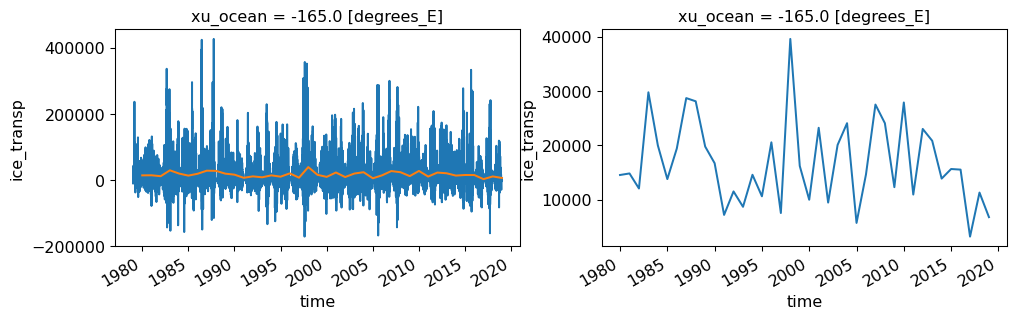

In [36]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
ice_transp.sum('yu_ocean').plot()
ice_transp.sum('yu_ocean').resample(
    time="1Y").mean(dim="time").plot()
plt.subplot(1, 2, 2)
ice_transp.sum('yu_ocean').resample(
    time="1Y").mean(dim="time").plot()
plt.show()

In [32]:
print('Mean (1979-2018) ice transport across 165W: ' + str(np.round(
    ice_transp.sum('yu_ocean').mean('time').values, 2)) +
      ' m3/s')
print('Mean (2002-2007) ice transport across 165W in years of high salinity: ' +
      str(np.round(ice_transp.sum('yu_ocean').sel(time=slice('2002', '2007')).mean(
          'time').values, 2)) + ' m3/s')
print('Mean (2010-2013) ice transport across 165W in years of low salinity: ' +
      str(np.round(ice_transp.sum('yu_ocean').sel(time=slice('2010', '2013')).mean(
          'time').values, 2)) + ' m3/s')

Mean (1979-2018) ice transport across 165W: 16864.32 m3/s
Mean (2002-2007) ice transport across 165W in years of high salinity: 19354.62 m3/s
Mean (2010-2013) ice transport across 165W in years of low salinity: 17184.42 m3/s


Estimate of ice transport into the Ross Sea doesn't agree with the idea that it should be lower in years of high salinity as that would reduce the sea ice concentration and increase the formation of sea ice